#### Auteurs : Lantrade Morgan, Appel Justin
<div class="alert alert-block alert-info">
<b>Remarque:</b> Rendu: Nous avons choisis de faire notre analyse à la fin du notebook plutôt que sur un fichier pdf. </div>


# Mini-Projet : Segmentation d'images TEP par classification spectrale

L'objectif de ce TP est de segmenter des images de Tomographie par Emission de Positons (TEP)  via des méthodes de classification non supervisée et, en particulier, une méthode de classification spectrale. 

## Principe de l'imagerie TEP 

La Tomographie par Emission de Positons (ou TEP) est une technique d'imagerie médicale fonctionnelle quantitative permettant de visualiser les activités du métabolisme. Les données TEP forment une sèquence *3D + t* qui traduit l'évolution de la radioactivité dans le temps du volume correspondant au champ de vue de l'appareil de mesure.
<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/PrincipePET.png"/></a>




Nous nous intéressons, dans ce TP, à la segmentation d'une coupe transverse et sagittale du cerveau, réprésentée respectivement à gauche et à droite sur la figure ci-dessous. Le nombre de classes à retrouver correspond aux différentes couleurs représentées sur la figure. Ici, l'information géométrique (position de chaque pixel dans l'image) n'est pas prise en compte.

<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/zubal_fig3.png"/></a>


Ce mini-projet se décompose en 5 parties:
* [**Partie I :** implémentation de la classification spectrale avec exemple jouet ](#chapter1)
* [**Partie II :** application de la classification spectrale sur les protils temporels TACs](#chapter2)
* [**Partie III :** classification par Kmeans puis par réduction de dimension ACP+Kmeans](#chapter3)
* [**Partie IV :** évaluation des résultats](#chapter4)
* [**Partie V :** votre analyse](#chapter5)




In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from numpy import linalg as LA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import classification_report

## Partie I : Classification spectrale <a class="anchor" id="chapter1"></a>

Parmi les méthodes de partitionnement non supervisé, les méthodes à noyaux reposent sur le même principe : elles utilisent des relations d'adjacence (d'affinité) entre tous les couples de points sans a priori sur les formes des classes. Nous nous concentrons sur l'algorithme de classification spectrale décrit ci-dessous, très simple à implémenter. La mesure d'affinité utilisée est l'affinité gaussienne qui dépend d'un paramètre noté $\sigma$.


On dispose d'un ensemble  de données $S=\{x_i\}_{i=1,..,n}\in \mathbb{R}^p$ composé de $n$ points de dimension $p$ et d'un nombre de classes, noté $k$, à obtenir. La méthode de classification spectrale  consiste à extraire les vecteurs propres associés aux plus grandes valeurs propres d'une matrice d'affinité normalisée. Ces vecteurs propres constituent ensuite un espace de dimension réduite dans lequel les données transformées seront linéairement séparables.  

<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/AlgoSC.png"/></a>


<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/SCexple.png"/></a>

### Travail demandé

- Ecrire la fonction **classification_spectrale** implantant l'algorithme 1. Cette fonction en entrée les données Input de l'algorithme.
- Tester la fonction sur le jeu de données *ToyExample.mat* et tester différentes valeurs de paramètres $\sigma$. Les résultats sont-ils similaires ?


### Fonctions python utiles
- exp (numpy)
- norm (linalg)
- inv (linalg)
- eig (linalg)
- KMeans (sklearn)

In [2]:
def reverse_sort(P,eigen_values):
    '''Return P sorted based on eigen_values'''
    order=np.argsort(-eigen_values)                                        #descending order
    sorted_P=np.hstack([ P[:,i].reshape(P.shape[0],1) for i in order])     #stack column in the right order
    eigen_values=np.array([ eigen_values[i] for i in order])
    return sorted_P,eigen_values

#Algo 1
#1
def affinityMatrix(X,sigma):
    '''Return the affinity matrix with parameter sigma'''
    distances=euclidean_distances(X,X)                                    #descending order
    norms=distances*distances                                             #square euclidean distance
    affinity_matrix=np.exp(-norms/(2*sigma*sigma))                        #i!=j
    np.fill_diagonal(affinity_matrix, 0)                                  #i=j
    return affinity_matrix

#2
def normalizedMatrix(X):
    '''Return the matrix normalized'''
    D= np.sum(X,axis=1).reshape(X.shape[0],1)                             #sum axis=line or colomn
    D_inv= np.zeros((X.shape), float)                                     # inv of D = 1/D
    np.fill_diagonal(D_inv, 1/D)
    L=np.dot(D_inv,X)
    return L
#3
def kMatrix(X,k):
    '''Return the matrix with k first eigen vectors'''
    eigen_values,P=np.linalg.eig(X)
    P,_=reverse_sort(P,eigen_values)
    new_P=P[:,:k]   # first k eigen_vectors
    return new_P
#4
def YMatrix(X):
    '''Return the Y matrix : normalized X'''
    return (X-X.mean(axis=0))/X.std(axis=0)
    
#5/6
def predict_K_mean(X,k):
    '''Return the prediction '''
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    return kmeans.predict(X)

def spectral_classification(Data,k,sigma):
    '''Return the prediction for spectral classification'''
    data=np.asarray(Data)
    A=affinityMatrix(data,sigma)
    L=normalizedMatrix(A)
    X=kMatrix(L,k)
    Y=YMatrix(X)
    prediction=predict_K_mean(Y,k)
    return prediction

############################################################
                    #VISUALISATION#
############################################################
def change_color_prediction(true_pred,pred):
    classe,classe_count=np.unique(true_pred,return_counts=True)
    classe_p,classe_count_p=np.unique(pred,return_counts=True)
    color1= { str(j) : classe[i] for j,i in enumerate(np.argsort(-classe_count)) }
    color2= { str(j) : classe_p[i] for j,i in enumerate(np.argsort(-classe_count_p)) }
    new_prediction=np.zeros(pred.shape)
    for c in color1.keys():
        if str(c) in color2: 
            new_prediction=np.where(pred==color2[str(c)],color1[str(c)],new_prediction)
    #to verify that FMI doesnt change
    assert round(fowlkes_mallows_score(true_pred,pred),2)==round(fowlkes_mallows_score(true_pred,new_prediction),2) ,'FMI changed'
    return new_prediction

def show_affinityMatrices(X,sigmas):
    n=len(sigmas)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4),sharey=True)
    fig.suptitle("Affinity matrix")
    for i,s in enumerate(sigmas):
        A=normalizedMatrix(affinityMatrix(X,s))
        sns.heatmap(A,ax=axes[i],cbar=(i==(n-1)))
        axes[i].set_title(f'With sigma = {s}')

def show_spectralC(data,sigmas,k):
    n=len(sigmas)
    fig, axes = plt.subplots(n//2, 4, figsize=(4*n, 2*n))
    plt.subplots_adjust(bottom=0.1, top=0.95)
    colors=list(i for i in range(k))
    for i,s in enumerate(sigmas):
        A=affinityMatrix(data,s)
        L=normalizedMatrix(A)
        X=kMatrix(L,k)
        Y=YMatrix(X)
        kmeans = KMeans(n_clusters=k,random_state=0).fit(Y)
        prediction= kmeans.predict(Y)
        centers=kmeans.cluster_centers_
        if n==1:
            axes[0].scatter(data[:,0],data[:,1],marker='.',c=prediction,cmap=plt.cm.Set1)
            axes[1].scatter(Y[:,0],Y[:,1],marker='.',c=prediction,cmap=plt.cm.Set1)
            axes[1].scatter(centers[:,0],centers[:,1],marker='X',s=100,c=colors,cmap=plt.cm.Set1)
            axes[1].set_title(f'Y with sigma = {s} and k = {k}')
        else:
            axes[i%2,i//2*2].scatter(data[:,0],data[:,1],marker='.',c=prediction,cmap=plt.cm.Set1)
            axes[i%2,i//2*2+1].scatter(Y[:,0],Y[:,1],marker='.',c=prediction,cmap=plt.cm.Set1)
            axes[i%2,i//2*2+1].scatter(centers[:,0],centers[:,1],marker='X',s=100,c=colors,cmap=plt.cm.Set1)
            axes[i%2,i//2*2+1].set_title(f'Y with sigma = {s} and k = {k}')   

### Application : toy example

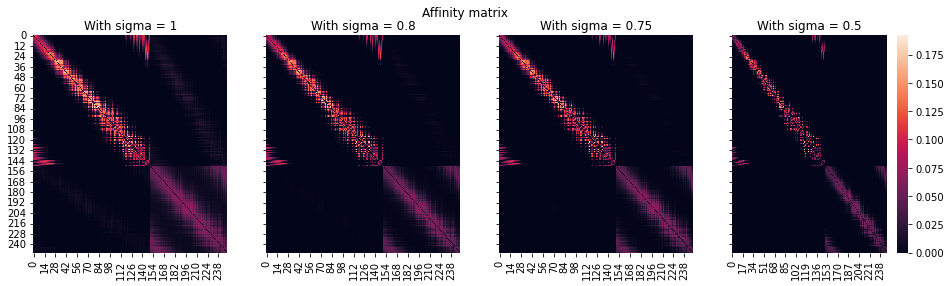

In [3]:
matJouet = scipy.io.loadmat('ToyExample.mat')
ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)
sigmas=[1,0.8,.75,0.5]
show_affinityMatrices(ExpleJouet,sigmas)

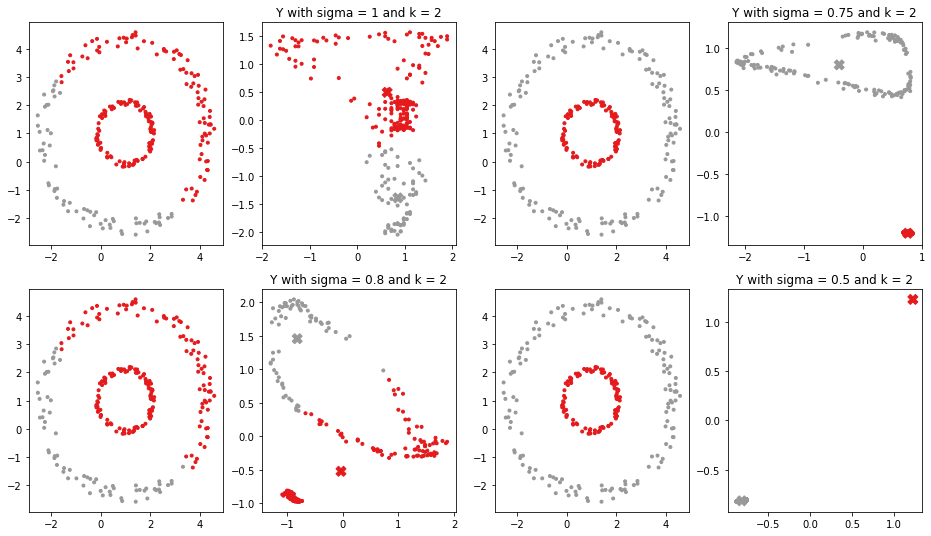

In [4]:
show_spectralC(ExpleJouet,sigmas,2)

<div class="alert alert-block alert-info">
<b>Remarque:</b> A partir d'une certaine valeur de <b>sigma</b> infèrieure à 0.8, sur l'image de la classification spectrale, les deux classifications semblent correctes. </div>

# Partie II : application de la classification spectrale sur les protils temporels TACs  <a class="anchor" id="chapter2"></a>

La segmentation des images TEP repose donc sur une classification de profils temporels très bruités sans disposer de connaissance a priori.  Ces profils temporels s'appellent des courbes Temps-Activité (notées TAC pour *Time Activity Curves*). Comme ils traduisent l'évolution de la radioactivité, elles comportent principalement 2 phases : une phase de croissance  suivie d'une phase de décroissance. Suivant les tissus, les profils temporels vont présenter  différentes amplitudes et des phases de croissance et de décroissance de durées plus ou moins longues. 

La simulation numérique est couramment utilisée dans le domaine du traitement d'image. Elle
constitue une aide précieuse pour le développement et l'évaluation de méthodes car elle permet de
disposer d'une vérité terrain à laquelle on va comparer les résultats obtenus. Un exemple de simulation de TACs est représenté sur la figure suivante

Dans l'imagerie médicale, ces simulations sont généralement effectuées selon la méthode Monte-Carlo, particulièrement adaptées à la physique nucléaire à
cause de la nature stochastique des processus d'émission, de transport et de détection.


<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/TAC_simu_reel.png"/></a>

On dispose de données temporelles simulées (séquences de 20 instants) d'une coupe transverse et d'une coupe sagittale de taille $64\times 54$ (représentées sur la figure ci-dessus) que l'on souhaite segmenter sans prendre en compte l'information géométrique. On dispose aussi de la vérité terrain c'est-à-dire de la segmentation de ces coupes avant simulation. Ces matrices sont stockées respectivement dans les fichiers *DataTAC_S.mat* et *DataTAC_T.mat*.



Nombre de TAC de la coupe Sagittale : (3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)



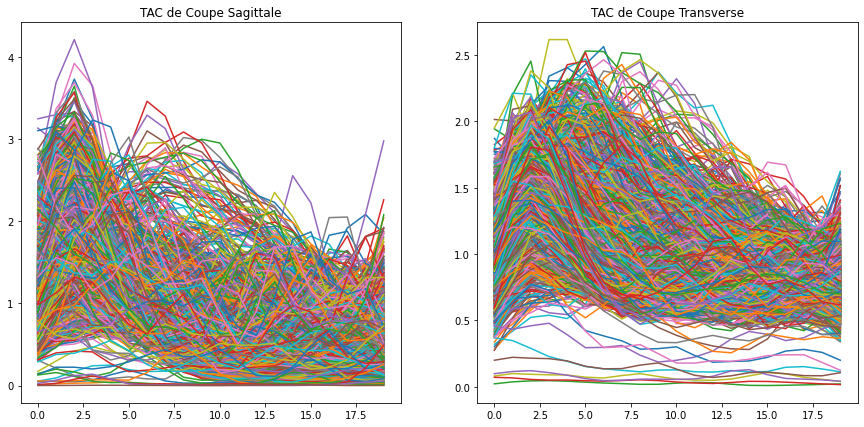

In [5]:
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

print('Nombre de TAC de la coupe Sagittale :', data_T.shape)

# Chargement de la coupe transverse
dataROITrans= scipy.io.loadmat('ImageROI_DataTransverse.mat') 
dataROI_T = pd.DataFrame(dataROITrans['Image_ROI_T'])
dataROISagit= scipy.io.loadmat('ImageROI_DataSagittale.mat') 
dataROI_S = pd.DataFrame(dataROISagit['Image_ROI_S'])

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_S=np.ravel(dataROI_S)
# Coupe Transverse : Vectorisation de l'image de verité terrain
VecdataROI_T=np.ravel(dataROI_T)


# Affichage des TAC des deux coupes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(data_S.T)
axs[0].set_title('TAC de Coupe Sagittale')
axs[1].plot(data_T.T)
axs[1].set_title('TAC de Coupe Transverse')
print()

In [6]:
def showSpectralCLassification(k,y_true,X,sigma):
    prediction=spectral_classification(X,k,sigma)
    prediction=change_color_prediction(y_true,prediction)
    f2=fowlkes_mallows_score(y_true,prediction)
    # Redimensionnement de la partition de la coupe saggitale en (54,64)
    Image=np.reshape(prediction,((54,64)))
    plt.imshow(Image.T)
    plt.title(f' FMI :{round(f2,5)}')
    return prediction,f2,Image
k_meanSC=7
k_meanT=5

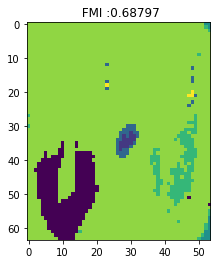

In [7]:
prediction2,f2,ImSagittaleSC=showSpectralCLassification(7,VecdataROI_S,data_S,0.26)
print()

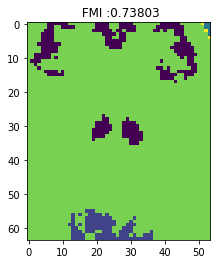

In [8]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 5 classes
prediction3,f3,ImTransverseSC=showSpectralCLassification(5,VecdataROI_T,data_T,0.35)
print()

<div class="alert alert-block alert-info">
<b>Remarque:</b> 
    
Augmenter le sigma, augmente le FMI mais le résultat n'est pas meilleur graphiquement.
    
Baisser le nombre de clusters augmente le FMI mais le résultat n'est pas meilleur graphiquement. 

<b>Le paramètre sigma semble influencer la sensibilité de la detection de cluster et donc se trompe plus souvent.</b>  </div>

# Partie III : comparaison avec  kmeans (+ ACP) <a class="anchor" id="chapter3"></a>

- Réaliser une classification avec le kmeans de sklearn
- Tester aussi une réduction de dimension par ACP comme étape de prétraitement qui conserverait 95% de l'information

In [9]:
def inertia(k,eigen_values):
    '''Return the inertia of the k th component '''
    total=np.sum(eigen_values)
    return np.sum(eigen_values[:k])/total

def total_inertia(k,eigen_values):
    '''Return the inertia of the k first components '''
    the_range_inertia=list(range(k+1))
    return the_range_inertia,[ inertia(k,eigen_values) for k in the_range_inertia]

def eigen_value_distribution(k,eigen_values):
    '''Return the eigen values distribution'''
    the_range_distrib=list(range(1,k+1))
    return the_range_distrib,[ eigen_values[k-1] for k in the_range_distrib]

def PCA(X,taux=0.95):
    '''Return X with an ACP reduction,eigen_values and k'''
    M=np.cov(X.T)
    M=np.round(M,15)
    eigen_values,P=np.linalg.eig(M)
    P,eigen_values=reverse_sort(P,eigen_values)
    k=0
    while inertia(k,eigen_values)<taux:
        k+=1
    new_P=P[:,:k]
    new_X=np.dot(new_P.T,X.T).T
    return new_X,eigen_values,k

############################################################
                    #VISUALISATION#
############################################################
def show_inertia_distribution(n_first_components,eigen_values):
    '''Show the total inertia and eigen values distribution of the n first components'''
    #ranges
    the_range_inertia,inertia=total_inertia(n_first_components,eigen_values)
    the_range_distrib,distrib=eigen_value_distribution(n_first_components,eigen_values)
    #visual
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    axs[0].plot(the_range_inertia,inertia)
    axs[0].set_ylabel('inertia')
    axs[0].set_title(f'Total inertia of the {n_first_components} first components')
    axs[1].set_xlabel(f'{n_first_components} first components')
    axs[1].bar(the_range_distrib,distrib,1)
    axs[1].set_xlabel(f'{n_first_components} first components')
    axs[1].set_title(f'Eigen values distribution')
    axs[1].set_ylabel('eigen value')

def show_KMeans(X,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    prediction= kmeans.predict(X)
    centres=kmeans.cluster_centers_
    colors=list(i for i in range(k))
    plt.title("KMeans for the 2 first components")
    plt.scatter(X[:,0],X[:,1],marker='.',c=prediction,cmap=plt.cm.Set1)
    plt.scatter(centres[:,0],centres[:,1],marker='X',s=100,c=colors,cmap=plt.cm.Set1)
    plt.show()
    
   
    

##  toy example 

Pour conserver 95% des informations, nous devons garder les 2 premieres composantes


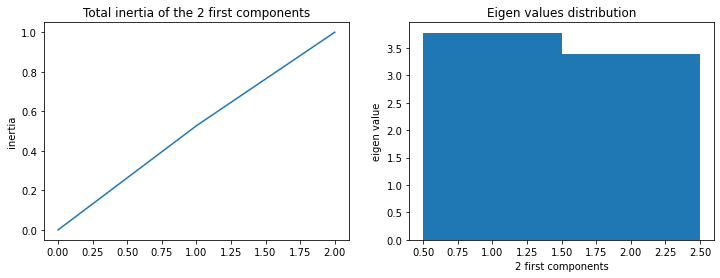

In [10]:
new_X,eigen_values,k=PCA(ExpleJouet,0.95)
show_inertia_distribution(len(eigen_values),eigen_values)
print(f'Pour conserver 95% des informations, nous devons garder les {k} premieres composantes')

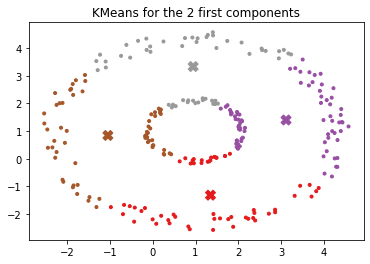

In [11]:
show_KMeans(ExpleJouet,4)

##   TACS

### Sagittale

Pour conserver 95% des informations, nous devons garder les 7 premieres composantes


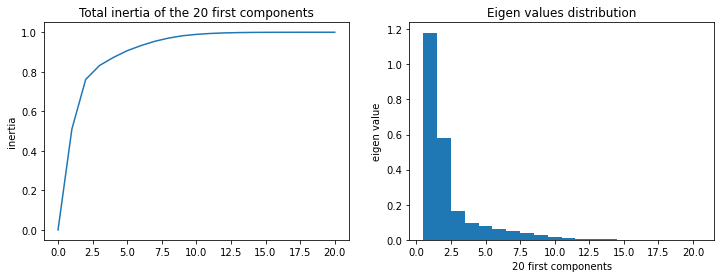

In [12]:
new_X1,eigen_values,k=PCA(data_S,0.95)
show_inertia_distribution(len(eigen_values),eigen_values)
print(f'Pour conserver 95% des informations, nous devons garder les {k} premieres composantes')

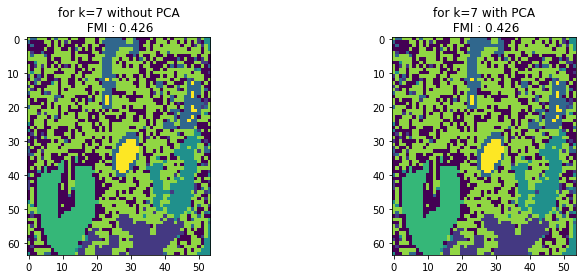

In [13]:
def k_mean_classification(y_true,X,X_PCA,k):
    #without PCA
    prediction=predict_K_mean(X,k)
    prediction=change_color_prediction(y_true,prediction)
    f=fowlkes_mallows_score(y_true,prediction)
    Image=np.reshape(prediction,(54,64))
    #with PCA
    predictionPCA=predict_K_mean(X_PCA,k)
    predictionPCA=change_color_prediction(y_true,predictionPCA)
    fPCA=fowlkes_mallows_score(y_true,predictionPCA)
    Image_PCA=np.reshape(predictionPCA,(54,64))
    #show
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    axs[0].imshow(Image.T)
    axs[0].set_title(f'for k={k} without PCA\n FMI : {round(f,3)}')
    axs[1].imshow(Image_PCA.T)
    axs[1].set_title(f'for k={k} with PCA\n FMI : {round(fPCA,3)}')
    
    return prediction,predictionPCA,f,fPCA,Image,Image_PCA

prediction_4,predictionPCA_4,f4,f4_PCA,ImSagittaleSC2,ImSagittaleSC2_PCA = k_mean_classification(VecdataROI_S,data_S,new_X1,7)   

print()

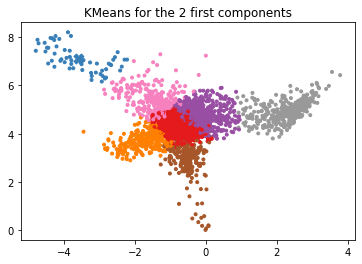

In [14]:
show_KMeans(new_X1,k_meanSC)

### Transverse

Pour conserver 95% des informations, nous devons garder les 8 premieres composantes


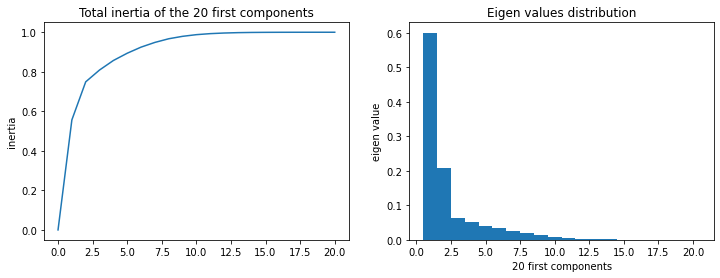

In [15]:
new_X2,eigen_values,k=PCA(data_T,0.95)
show_inertia_distribution(len(eigen_values),eigen_values)
print(f'Pour conserver 95% des informations, nous devons garder les {k} premieres composantes')

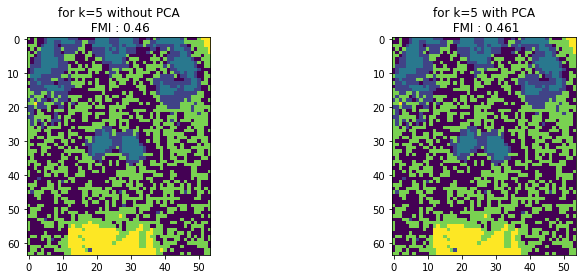

In [16]:
prediction_5,predictionPCA_5,f5,f5_PCA,ImTransverseSC2,ImTransverseSC2_PCA = k_mean_classification(VecdataROI_T,data_T,new_X2,5)   

print()

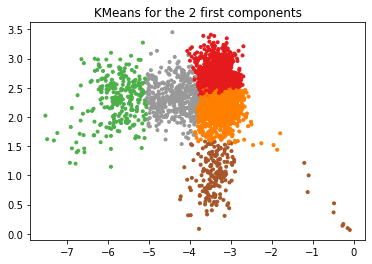

In [17]:
show_KMeans(new_X2,k_meanT)

<div class="alert alert-block alert-info">
<b>Remarque:</b> 
    
Les résultats sont très mauvais sur le k-mean si le k est trop élevé.
    
<b>La réduction par ACP semble très peu influencer les resultats, ce qui est logique si l'on garde 95% des informations.
Comme on peut le voir si-dessus, tester de réduire en ne gardant que les 2 premières composantes ne semblent pas être une mauvaise idée.</b>  </div>

# Partie IV : Comparaison avec vérité terrain <a class="anchor" id="chapter4"></a>


En utilisant la vérité terrain des coupes (repectivement les matrices *ImageROI_DataSagittale*, *Image_ROI_DataTransverse*, analyser vos résultats et améliorer les.


<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/TAC_simu_reel.png"/></a>


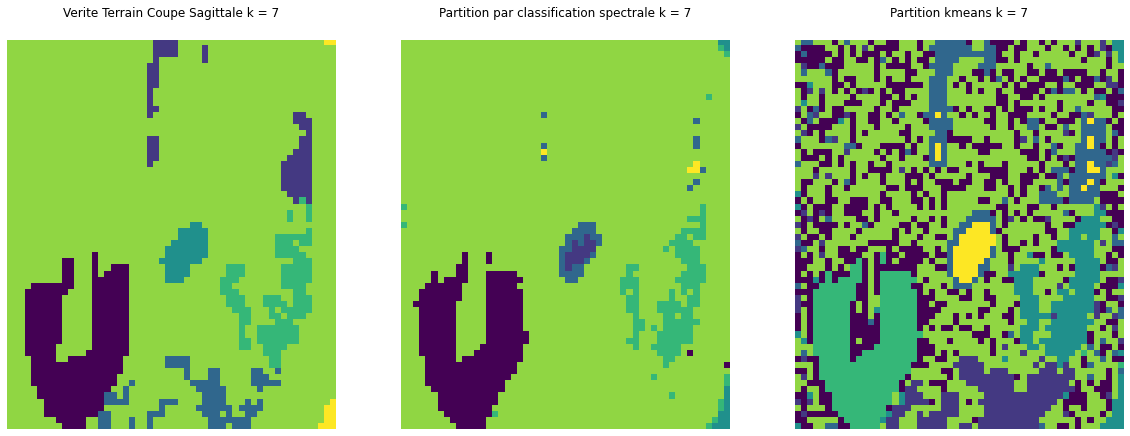

In [18]:
# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_S)
axs[0].set_title('Verite Terrain Coupe Sagittale k = 7')
axs[0].set_axis_off()
axs[1].matshow(ImSagittaleSC.T)
axs[1].set_title(f'Partition par classification spectrale k = {k_meanSC}')
axs[1].set_axis_off()
axs[2].matshow(ImSagittaleSC2.T) 
axs[2].set_title(f'Partition kmeans k = {k_meanSC}')
axs[2].set_axis_off()


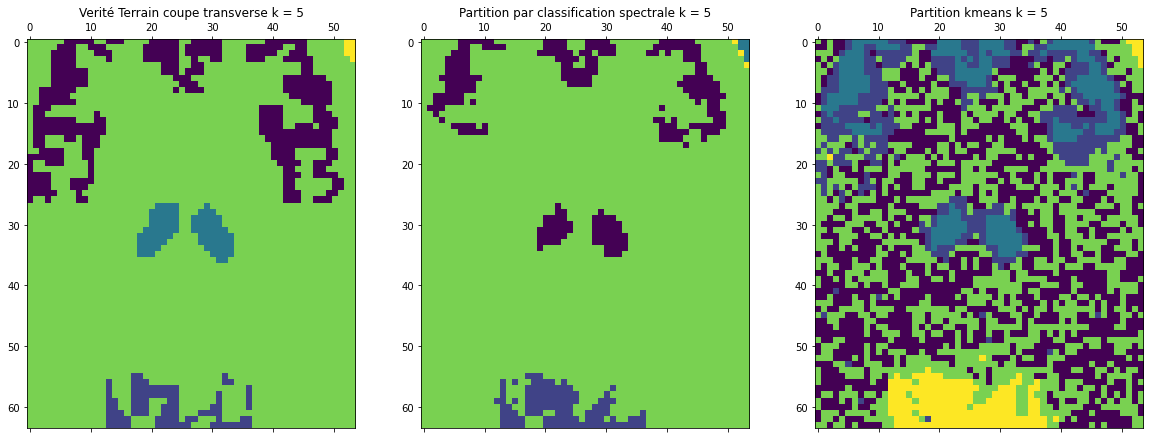

In [19]:
# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_T)
axs[0].set_title('Verité Terrain coupe transverse k = 5')
axs[1].matshow(ImTransverseSC.T)
axs[1].set_title(f'Partition par classification spectrale k = {k_meanT}')
axs[2].matshow(ImTransverseSC2.T) # à modifier par Image issue du Kmeans
axs[2].set_title(f'Partition kmeans k = {k_meanT}')
print()

## Calcul de mesures de précision et rappel 

**Précision :** évalue l'exactitude des prédictions positives
$$Precision=\frac{TP}{TP+FP}$$
**Rappel :** évalue le taux d'observations positives ayant été correctement détectées par le classifieur
$$Rappel = \frac{TP}{TP+FN}$$

<img src="https://github.com/morganLantrade/TP_M1/raw/main/TP_CS/assets_miniProjet/PrecisionRappel.png"/></a>



**Indice de Fowlkes-Mallows index (FMI)** mesure la similarité entre deux partitionnements. C'est une moyenne géométrique entre la précision et le rappel :

$$FMI = \frac{TP}{\sqrt{TP + FP) * (TP + FN)}}$$

Resultat Sagittale - Classification Spectrale : 0.6879687289854438
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       302
         2.0       0.00      0.00      0.00        89
         3.0       0.00      0.00      0.00       101
         4.0       0.00      0.00      0.00        50
         5.0       0.08      0.08      0.08       143
         6.0       0.80      0.85      0.82      2759
         7.0       0.00      0.00      0.00        12

    accuracy                           0.68      3456
   macro avg       0.12      0.13      0.13      3456
weighted avg       0.64      0.68      0.66      3456



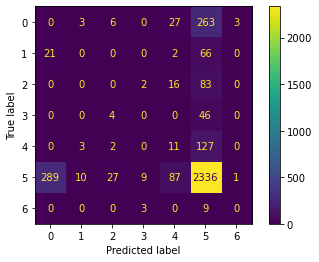

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
print('Resultat Sagittale - Classification Spectrale :',f2)
cm = confusion_matrix(VecdataROI_S,prediction2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(VecdataROI_S,prediction2))

Resultat Transverse - Classification Spectrale : 0.7380338582179793
              precision    recall  f1-score   support

         2.0       0.08      0.05      0.06       414
         3.0       0.00      0.00      0.00        93
         4.0       0.00      0.00      0.00        86
         6.0       0.82      0.88      0.85      2856
         7.0       0.00      0.00      0.00         7

    accuracy                           0.73      3456
   macro avg       0.18      0.19      0.18      3456
weighted avg       0.69      0.73      0.71      3456



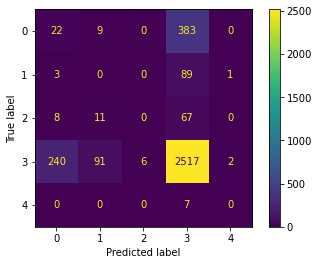

In [21]:
# Mesure d'évalution pour la coupe transverse  pour la classification spectrale
print('Resultat Transverse - Classification Spectrale :',f3)
cm = confusion_matrix(VecdataROI_T,prediction3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(VecdataROI_T,prediction3))

<div class="alert alert-block alert-info">
<b>Remarque:</b> 
    
On remarque bien que le f1-score de la classe majoritaire a un énorme impact sur le score.
    
    
</div>

In [22]:
from sklearn.metrics import f1_score
# Mesure d'évalution pour la coupe sagittale  pour le Kmeans 
print('Resultat Sagittale - Kmean :',f4)
print(f'f1-score: \n{f1_score(VecdataROI_S,prediction_4, average=None)} ')
# Mesure d'évalution pour la coupe sagittale  pour le Kmeans apres ACP 
print('Resultat Sagittale - Kmean - ACP :',f4_PCA)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans 
print('Resultat Transverse - Kmean :',f5)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans apres ACP
print('Resultat Transverse - Kmean - ACP :',f5_PCA)

Resultat Sagittale - Kmean : 0.4257792053316303
f1-score: 
[0.11101766 0.02339181 0.07202216 0.         0.         0.55799669
 0.        ] 
Resultat Sagittale - Kmean - ACP : 0.4257637238403479
Resultat Transverse - Kmean : 0.4603589305374049
Resultat Transverse - Kmean - ACP : 0.4613607136565741


<div class="alert alert-block alert-info">
<b>Remarque:</b> 
    
Sans même afficher les matrices de confusion et les f1_scores , on observant les images on remarque qu'avec les classifications non supervisées de Kmeans, la classe majoritaire possède beaucoups moins d'éléments. Ce qui veut dire que le f1-score de cette classe est beaucoups plus faible, d'où un score faible. 

<b>Exemple pour le Kmean sagittale :</b>  f1_score = 0.557 pour la classe majoritaire.
    
    
</div>

# Partie V : votre analyse <a class="anchor" id="chapter5"></a>

A partir des méthodes que vous avez implémentées, sur le notebook 
- Réaliser une analyse sur les résultats des méthodes de classification non supervisée : classification spectrale, kmeans et ACP+kmeans
- Tester pour différentes valeurs de paramètres $\sigma$ et de classes 

Rédiger sur un cartouche l'analyse effectuée et vos conclusions.

Le notebook sera à rendre sur moodle. 

## Quelques tests

### Kmean avec k plus faible

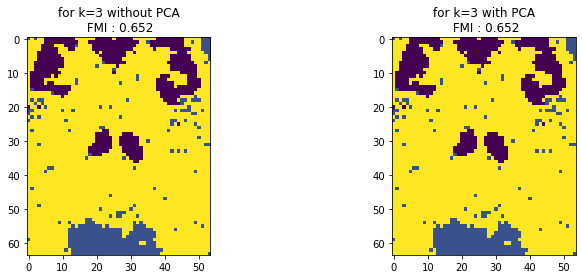

In [23]:
_=k_mean_classification(VecdataROI_T,data_T,new_X2,3)   

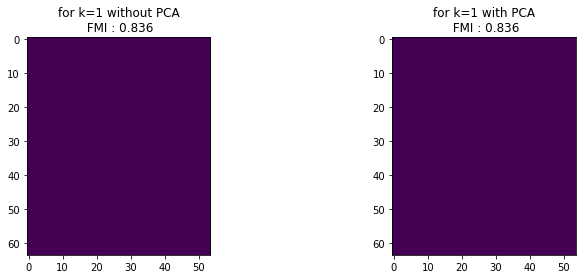

In [24]:
pred,_,_,_,_,_=k_mean_classification(VecdataROI_T,data_T,new_X2,1)   

In [25]:
print(f'f1-score: \n{f1_score(VecdataROI_T,pred, average=None)} ')

f1-score: 
[0.         0.         0.         0.90494297 0.        ] 


<div class="alert alert-block alert-info">
<b>Remarque:</b> 
    
On observe bien l'impact du score f-1 de la classe principale sur le FMI.
  
Graphiquement pour k=3, la classification semble se rapprocher de la vérité.    
</div>

## ANALYSE










### Classification spectrale

Après implémentation de la classification spectrale, nous avous pu tester différents sigma sur les 3 jeux de données.
Nous avons observé que le sigma augmente "la sensibilité" de la detection de cluster, ce qui provoque une modification des formes de clusters. Voir ci-dessous

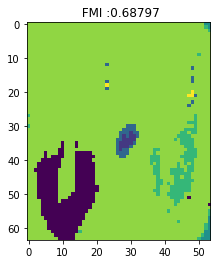

In [26]:
prediction2,f2,ImSagittaleSC=showSpectralCLassification(7,VecdataROI_S,data_S,0.26)

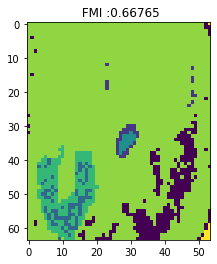

In [27]:
prediction2,f2,ImSagittaleSC=showSpectralCLassification(7,VecdataROI_S,data_S,0.86)

### Classification Kmean

   Après avoir tester la classification Kmean, nous avons observé une différente nette avec la classification spectrale, 
néanmoins, elle s'apparente à une classification spectrale avec un sigma elévé.

   Il semblerait (visuellement) que baisser le nombre de clusters permet d'obtenir une meilleure classification.

### ACP

La réduction par ACP semble n'avoir aucun(très peu) d'impact sur la classification, ce qui est logique étant donné qu'on garde 95% des informations.

Néanmoins, si la dimension des données était beaucoups plus élevée, l'ACP aurait un réel intérêt sur le temps de calcul.

Finalement, après quelques tests, une réduction par ACP à 2 composantes n'améliore pas la classification même si graphiquement cela semblait intéressant. Cela pourrait être expliqué par le fait qu'en 2D, nous ne pouvons pas distinguer les points qui sont superposés.

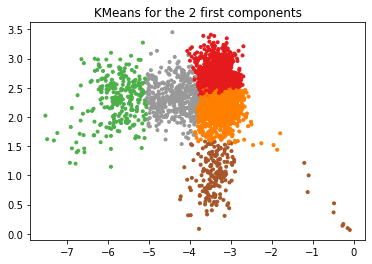

In [28]:
show_KMeans(new_X2,k_meanT)

### Mesure

Nous essayons de mesurer l'efficacité d'un clustering. Du fait que la majeure partie (83% environ) des points appartiennent à la même classe, l'outil fowlkes_mallows_score nous permet pas de déterminer le nombre de cluster ou sigma qui optimiserait la classification car visuellement on se rend compte que l'augmentation du score ne correspond pas la visibilité des clusters sur les graphiques.

On s'est rendu compte que le f1-score de la classe principale influence trop le FMI comparé au cardinal négligeable des autres classes.

Néanmoins, il nous permet tout de même de comparer les différentes classifications pour le même nombre de clusters.

### Conclusion

La majorité de notre jugement s'appuie sur notre observation "à l'oeil" des différents graphes obtenus.
Il semblerait qu'une classification spectrale avec un sigma faible soit plus adapté à nos données.
Néanmoins, baisser le nombre de clusters de la classification Kmean permet de se rapprocher de meilleurs résultats.